Article source: http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

A **cohort** is a group of users who share something in common, be it their sign-up date, first purchase month, birth date, acquisition channel, etc.

**Cohort analysis** is the method by which these groups are tracked over time, helping you spot trends, understand repeat behaviors (purchases, engagement, amount spent, etc.), and monitor your customer and revenue retention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

In [4]:
df = pd.read_excel('data/cohort_analysis/chapter-12-relay-foods.xlsx', sheetname='Purchase Data - Full Study')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2891 entries, 0 to 2890
Data columns (total 7 columns):
OrderId         2891 non-null int64
OrderDate       2891 non-null datetime64[ns]
UserId          2891 non-null int64
TotalCharges    2891 non-null float64
CommonId        2891 non-null object
PupId           2891 non-null int64
PickupDate      2891 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 180.7+ KB


### 1. Create a period column based on the OrderDate

In [14]:
df['OrderPeriod'] = df.OrderDate.map( lambda x: x.strftime('%Y-%m') )
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


### 2. Determine the user's cohort group (based on their first order)

In [15]:
df.set_index('UserId', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply( lambda x: x.strftime('%Y-%m') )
df.reset_index(inplace=True)
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


### 3. Rollup data by CohortGroup & OrderPeriod

In [23]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# Count the unique users, orders and total revenue per Group + Period
cohorts = grouped.agg( {'UserId': pd.Series.nunique,
                        'OrderId': pd.Series.nunique,
                        'TotalCharges': np.sum} )

# Make the column names more meaningful
cohorts.rename( columns={'UserId': 'TotalUsers',
                         'OrderId': 'TotalOrders'}, inplace=True )
cohorts.head()

TotalOrders  TotalUsers  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01               30          22      1850.255
            2009-02               25           8      1351.065
            2009-03               26          10      1357.360
            2009-04               28           9      1604.500
            2009-05               26          10      1575.625

### 4. Label the CohortPeriod for each CohortGroup

In [24]:
def cohort_period(df):
    """
    Creates a 'CohortPeriod' column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime'], inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalOrders  TotalUsers  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01               30          22      1850.255             1
            2009-02               25           8      1351.065             2
            2009-03               26          10      1357.360             3
            2009-04               28           9      1604.500             4
            2009-05               26          10      1575.625             5

### 5. Make sure we did all that right

In [25]:
x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-01')]
y = cohorts.ix[('2009-01', '2009-01')]

assert x['UserId'].nunique() == y['TotalUsers']
assert x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2)
assert x['OrderId'].nunique() == y['TotalOrders']

x = df[(df.CohortGroup == '2009-01') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-01', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

x = df[(df.CohortGroup == '2009-05') & (df.OrderPeriod == '2009-09')]
y = cohorts.ix[('2009-05', '2009-09')]

assert(x['UserId'].nunique() == y['TotalUsers'])
assert(x['TotalCharges'].sum().round(2) == y['TotalCharges'].round(2))
assert(x['OrderId'].nunique() == y['TotalOrders'])

## User Retention by Cohort Group

We want to look at the percentage change of each `CohortGroup` over time - not the absolute change.

To do this, we'll first need to create a pandas **Series** containing each CohortGroup and its size.

In [26]:
# Reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# Create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

Now, we'll need to divide the `TotalUsers` values in `cohorts` by `cohort_group_size`. Since DataFrame operations are performed based on the indices of the objects, we'll use **`unstack`** on our `cohorts` DataFrame to create a matrix each column represents a CohortGroup and each row is the CohortPeriod corresponding to that group.

To illustrate what `unstack` does, recall the first five `TotalUsers` values:

In [31]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
Name: TotalUsers, dtype: int64

And here's what they look like when we `unstack` the CohortGroup level from the index:

In [32]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22,15,13,39,50,32,50,31,37,54,130,65,95,100,24
2,8,3,4,13,13,15,23,11,15,17,32,17,50,19,NaN
3,10,5,5,10,12,9,13,9,14,12,26,18,26,NaN,NaN
4,9,1,4,13,5,6,10,7,8,13,29,7,NaN,NaN,NaN
5,10,4,1,6,4,7,11,6,13,13,13,NaN,NaN,NaN,NaN


Now, we can utilize **`broadcasting`** to divide each column by the corresponding `cohort_group_size`.

The resulting DataFrame, `user_retention`, contains the percentage of users from the cohort purchasing within the given period. For instance, 38.4% of users in the 2009-03 purchased again in month 3 (which would be May 2009).

In [33]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


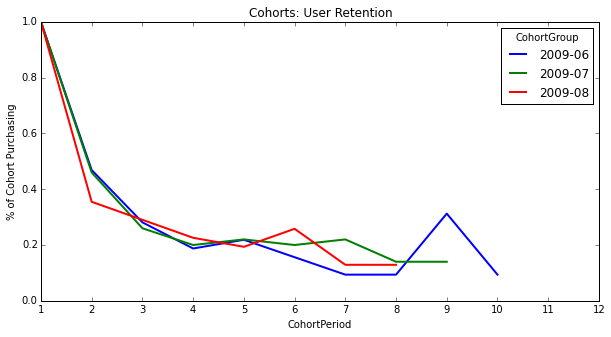

In [36]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10, 5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

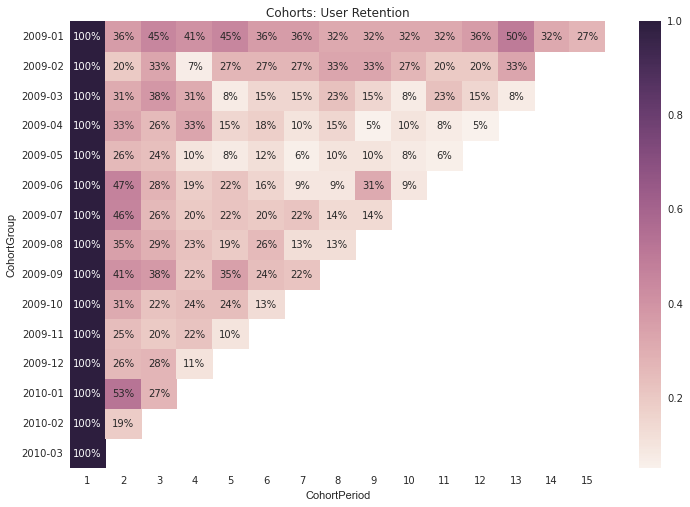

In [37]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

Unsurprisingly, we can see from the above chart that fewer users tend to purchase as time goes on.

However, we can also see that the 2009-01 cohort is the strongest, which enables us to ask targeted questions about this cohort compared to others -- what other attributes (besides first purchase month) do these users share which might be causing them to stick around? How were the majority of these users acquired? Was there a specific marketing campaign that brought them in? Did they take advantage of a promotion at sign-up? The answers to these questions would inform future marketing and product efforts.